In [1]:
import torch
torch.manual_seed(10)
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn import decomposition
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
import nltk
#Import stopwords
from nltk.corpus import stopwords

In [2]:
corpus = [
    'eat food',
    'drink ice water',
    'drink cold coffee',
    'drink juice',
    'drink cola',
    'eat bacon',
    'eat mango',
    'eat cherry',
    'eat salad',
    'juice with sugar',
    'cola with sugar',
    'mango is a fruit',
    'apple is a fruit',
    'cherry is fruit',
    'Berlin is in Germany',
    'Boston is in USA',
    'Mercedes from Germany',
    'Germany is prosperous'
]

In [3]:
def create_vocabulary(corpus):
    '''Creates a dictionary with all unique words in corpus with id'''
    vocabulary = {}
    i = 0
    for s in corpus:
        for w in s.split():
            if w not in vocabulary:
                vocabulary[w] = i
                i+=1
    return vocabulary


In [4]:
def prepare_set(corpus, n_gram = 1):
    '''Creates a dataset with Input column and Outputs columns for neighboring words. 
       The number of neighbors = n_gram*2'''
    columns = ['Input'] + [f'Output{i+1}' for i in range(n_gram*2)]
    result = pd.DataFrame(columns = columns)
    for sentence in corpus:
        for i,w in enumerate(sentence.split()):
            inp = [w]
            out = []
            for n in range(1,n_gram+1):
                # look back
                if (i-n)>=0:
                    out.append(sentence.split()[i-n])
                else:
                    out.append('<padding>')
                
                # look forward
                if (i+n)<len(sentence.split()):
                    out.append(sentence.split()[i+n])
                else:
                    out.append('<padding>')
            row = pd.DataFrame([inp+out], columns = columns)
            result = result.append(row, ignore_index = True)
    return result


In [5]:
def prepare_set_ravel(corpus, n_gram = 1):
    '''Creates a dataset with Input column and Output column for neighboring words. 
       The number of neighbors = n_gram*2'''
    columns = ['Input', 'Output']
    result = pd.DataFrame(columns = columns)
    for sentence in corpus:
        for i,w in enumerate(sentence.split()):
            inp = w
            for n in range(1,n_gram+1):
                # look back
                if (i-n)>=0:
                    out = sentence.split()[i-n]
                    row = pd.DataFrame([[inp,out]], columns = columns)
                    result = result.append(row, ignore_index = True)
                
                # look forward
                if (i+n)<len(sentence.split()):
                    out = sentence.split()[i+n]
                    row = pd.DataFrame([[inp,out]], columns = columns)
                    result = result.append(row, ignore_index = True)
    return result


In [6]:
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    result = []
    for i in corpus:
        out = nltk.word_tokenize(i)
        out = [x.lower() for x in out]
        out = [x for x in out if x not in stop_words]
        result.append(" ". join(out))
    return result

corpus = preprocess(corpus)
corpus

['eat food',
 'drink ice water',
 'drink cold coffee',
 'drink juice',
 'drink cola',
 'eat bacon',
 'eat mango',
 'eat cherry',
 'eat salad',
 'juice sugar',
 'cola sugar',
 'mango fruit',
 'apple fruit',
 'cherry fruit',
 'berlin germany',
 'boston usa',
 'mercedes germany',
 'germany prosperous']

In [7]:
vocabulary = create_vocabulary(corpus)
vocabulary

{'eat': 0,
 'food': 1,
 'drink': 2,
 'ice': 3,
 'water': 4,
 'cold': 5,
 'coffee': 6,
 'juice': 7,
 'cola': 8,
 'bacon': 9,
 'mango': 10,
 'cherry': 11,
 'salad': 12,
 'sugar': 13,
 'fruit': 14,
 'apple': 15,
 'berlin': 16,
 'germany': 17,
 'boston': 18,
 'usa': 19,
 'mercedes': 20,
 'prosperous': 21}

In [8]:
train_emb = prepare_set(corpus, n_gram = 2)
train_emb.head()

,Input,Output1,Output2,Output3,Output4
0,eat,<padding>,food,<padding>,<padding>
1,food,eat,<padding>,<padding>,<padding>
2,drink,<padding>,ice,<padding>,water
3,ice,drink,water,<padding>,<padding>
4,water,ice,<padding>,drink,<padding>


In [9]:
train_emb = prepare_set_ravel(corpus, n_gram = 2)
train_emb.head()

,Input,Output
0,eat,food
1,food,eat
2,drink,ice
3,drink,water
4,ice,drink


In [10]:
train_emb.Input = train_emb.Input.map(vocabulary)
train_emb.Output = train_emb.Output.map(vocabulary)
train_emb.head()

,Input,Output
0,0,1
1,1,0
2,2,3
3,2,4
4,3,2


In [11]:
vocab_size = len(vocabulary)

def get_input_tensor(tensor):
    '''Transform 1D tensor of word indexes to one-hot encoded 2D tensor'''
    size = [*tensor.shape][0]
    inp = torch.zeros(size, vocab_size).scatter_(1, tensor.unsqueeze(1), 1.)
    return Variable(inp).float()

In [12]:
embedding_dims = 5
device = torch.device('cpu')

In [13]:
initrange = 0.5 / embedding_dims
W1 = Variable(torch.randn(vocab_size, embedding_dims, device=device).uniform_(-initrange, initrange).float(), requires_grad=True) # shape V*H
W2 = Variable(torch.randn(embedding_dims, vocab_size, device=device).uniform_(-initrange, initrange).float(), requires_grad=True) #shape H*V
print(f'W1 shape is: {W1.shape}, W2 shape is: {W2.shape}')



W1 shape is: torch.Size([22, 5]), W2 shape is: torch.Size([5, 22])


In [14]:
num_epochs = 2000
learning_rate = 2e-1
lr_decay = 0.99
loss_hist = []

In [15]:
%%time
for epo in range(num_epochs):
    for x,y in zip(DataLoader(train_emb.Input.values, batch_size=train_emb.shape[0]), DataLoader(train_emb.Output.values, batch_size=train_emb.shape[0])):
        
        # one-hot encode input tensor
        input_tensor = get_input_tensor(x) #shape N*V
     
        # simple NN architecture
        h = input_tensor.mm(W1) # shape 1*H
        y_pred = h.mm(W2) # shape 1*V
        
        # define loss func
        loss_f = torch.nn.CrossEntropyLoss() # see details: https://pytorch.org/docs/stable/nn.html
        
        #compute loss
        loss = loss_f(y_pred, y)
        
        # bakpropagation step
        loss.backward()
        with torch.no_grad():
            # SGD optimization is implemented in PyTorch, but it's very easy to implement manually providing better understanding of process
            W1 -= learning_rate*W1.grad.data
            W2 -= learning_rate*W2.grad.data
            # zero gradients for next step
            W1.grad.data.zero_()
            W1.grad.data.zero_()
    if epo%10 == 0:
        learning_rate *= lr_decay
    loss_hist.append(loss)
    if epo%50 == 0:
        print(f'Epoch {epo}, loss = {loss}')
    

Epoch 0, loss = 3.0907812118530273
Epoch 50, loss = 2.782062292098999
Epoch 100, loss = 1.331791877746582
Epoch 150, loss = 0.9503133296966553
Epoch 200, loss = 0.8677059412002563
Epoch 250, loss = 0.861615777015686
Epoch 300, loss = 0.9515153765678406
Epoch 350, loss = 1.1333270072937012
Epoch 400, loss = 1.2854918241500854
Epoch 450, loss = 1.3707318305969238
Epoch 500, loss = 1.3555594682693481
Epoch 550, loss = 1.3332288265228271
Epoch 600, loss = 1.2586188316345215
Epoch 650, loss = 1.151679277420044
Epoch 700, loss = 1.073954463005066
Epoch 750, loss = 1.0077491998672485
Epoch 800, loss = 0.9684407711029053
Epoch 850, loss = 0.9424553513526917
Epoch 900, loss = 0.9172224402427673
Epoch 950, loss = 0.8997395038604736
Epoch 1000, loss = 0.8887062072753906
Epoch 1050, loss = 0.8783007264137268
Epoch 1100, loss = 0.8692291378974915
Epoch 1150, loss = 0.8665425777435303
Epoch 1200, loss = 0.8662704825401306
Epoch 1250, loss = 0.8657791614532471
Epoch 1300, loss = 0.8653044104576111
Ep

In [16]:
W1 = W1.detach().numpy()
W2 = W2.T.detach().numpy()

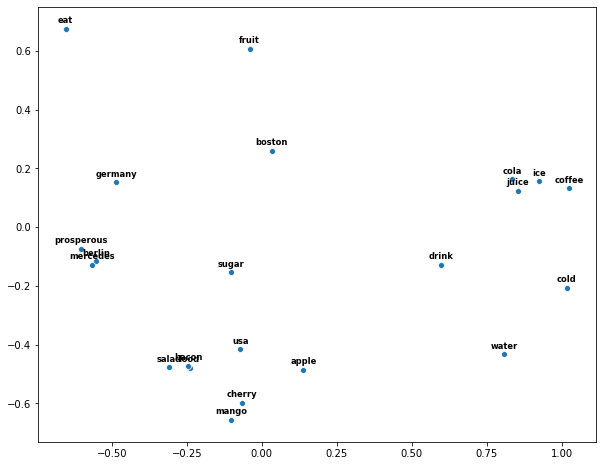

In [17]:
svd = decomposition.TruncatedSVD(n_components=2)
W1_dec = svd.fit_transform(W1)
x = W1_dec[:,0]
y = W1_dec[:,1]
plot = sns.scatterplot(x, y)

for i in range(0,W1_dec.shape[0]):
     plot.text(x[i], y[i]+2e-2, list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='semibold');

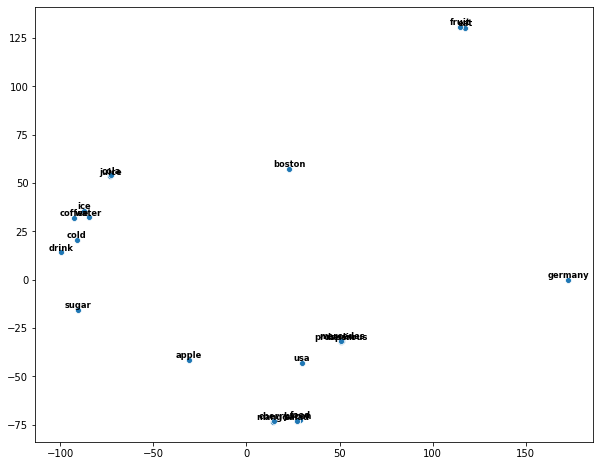

In [18]:
W2_dec = svd.fit_transform(W2)
x1 = W2_dec[:,0]
y1 = W2_dec[:,1]
plot1 = sns.scatterplot(x1, y1)
for i in range(0,W2_dec.shape[0]):
     plot1.text(x1[i], y1[i]+1, list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='semibold');